In [5]:
import sys
sys.path.append('../scripts')
import pandas as pd
import proplot as pplt
import matplotlib as mpl
import os
from helpers import *
import xarray as xr
import numpy as np
import datetime

def print(*val):
    display(*val)

In [6]:
# %run ../scripts/process_stations.py

In [7]:
# data = sic_data["sea_ice_concentration"].values

# fig = pplt.figure()

# cmap = pplt.Colormap('inferno')

# newcolors = cmap(np.linspace(0, 1, 120))
# newcolors[:15] = np.array([0.5,0.5,0.5,1])
# newcolors[109:] = np.array([0,0,0,1])


# n = 6
# dt = 25

# ax = fig.subplots(nrows=(n+2)//3, ncols=3)

# for i in range(n):
#     snapshot = np.rot90(data[dt*i].T)
#     h = ax[i].pcolormesh(snapshot, cmap=newcolors)

# fig.colorbar(h, loc='r')
# ax.format(xlocator='null', ylocator='null')

# Last Day in Ice

In [8]:
def varClassifier(df, var, newcol, intervals : list[tuple]):
    for i, interval in enumerate(intervals):
        df.loc[np.logical_and(df[var] >= interval[0], df[var] < interval[1]), newcol] = i
    df = df.dropna()
    df = df.astype({newcol: int})
    return df
season_ranges = [
    (pd.to_datetime("2019-09-01"), pd.to_datetime("2019-11-30")),
    (pd.to_datetime("2019-11-30"), pd.to_datetime("2020-03-31")),
    (pd.to_datetime("2020-03-31"), pd.to_datetime("2020-05-30")),
    (pd.to_datetime("2020-05-30"), pd.to_datetime("2020-10-01"))
]
seasons = ["Freeze-up (Oct-Nov)", "Midwinter (Dec-Mar)", "Melt Onset (Apr-May)", "Summer (Jun-Sep)"]

sic_data = xr.open_dataset("../data/sea_ice_concentration/amsr2_sea_ice_concentration.nc")
cropped = sic_data.isel(x=slice(100,250),y=slice(175,325))
sic = cropped["sea_ice_concentration"]

# Sea ice observations times
times = sic["time"].values

# The x-y grid
xvals = sic['x'].values
yvals = sic['y'].values

In [9]:
def cropBuoyTrack(track, dt="datetime", x="x_stere", y="y_stere"):
    new_track = track[track[dt] > pd.to_datetime("2020-04-30")]

    for time, x_pos, y_pos in zip(new_track[dt], new_track[x], new_track[y]):
        conc = sic.sel(time=time, x=x_pos, y=y_pos, method="nearest").values.tolist()
        if conc < 15:
            return new_track[new_track[dt] < time]
    return track

In [14]:
def getMeltTimes(data):
    water_indicator = data <= 15
    ice_indicator = np.logical_and(data > 15, data <= 100)
    other_indicator = data > 100

    always_water = water_indicator.all(dim="time")
    always_ice = ice_indicator.all(dim="time")
    always_other = other_indicator.all(dim="time")

    first_water = water_indicator.argmax(dim="time").values
    first_water[always_ice] = len(times) - 1
    first_water[always_other] = -1
    first_water[always_water] = -1
    
    return first_water
def dateFormatter(val, _):
    dt = pd.to_datetime(times[int(val)])
    return dt.month_name()[:3] + " " + str(dt.year)

def legend_without_duplicate_labels(ax):
    handles, labels = ax.get_legend_handles_labels()
    unique = [(h, l) for i, (h, l) in enumerate(zip(handles, labels)) if l not in labels[:i]]
    ax.legend(handles = [h[0] for h in unique], labels = [l[1] for l in unique], loc="lower left")

In [11]:
def toLatLon(x, y):
    projIn = 'epsg:3413' # WGS 84 Ellipsoid
    projOut = 'epsg:4326' # NSIDC North Polar Stereographic
    transformer = pyproj.Transformer.from_crs(projIn, projOut, always_xy=True)

    lon, lat = transformer.transform(x, y)
    return lon, lat

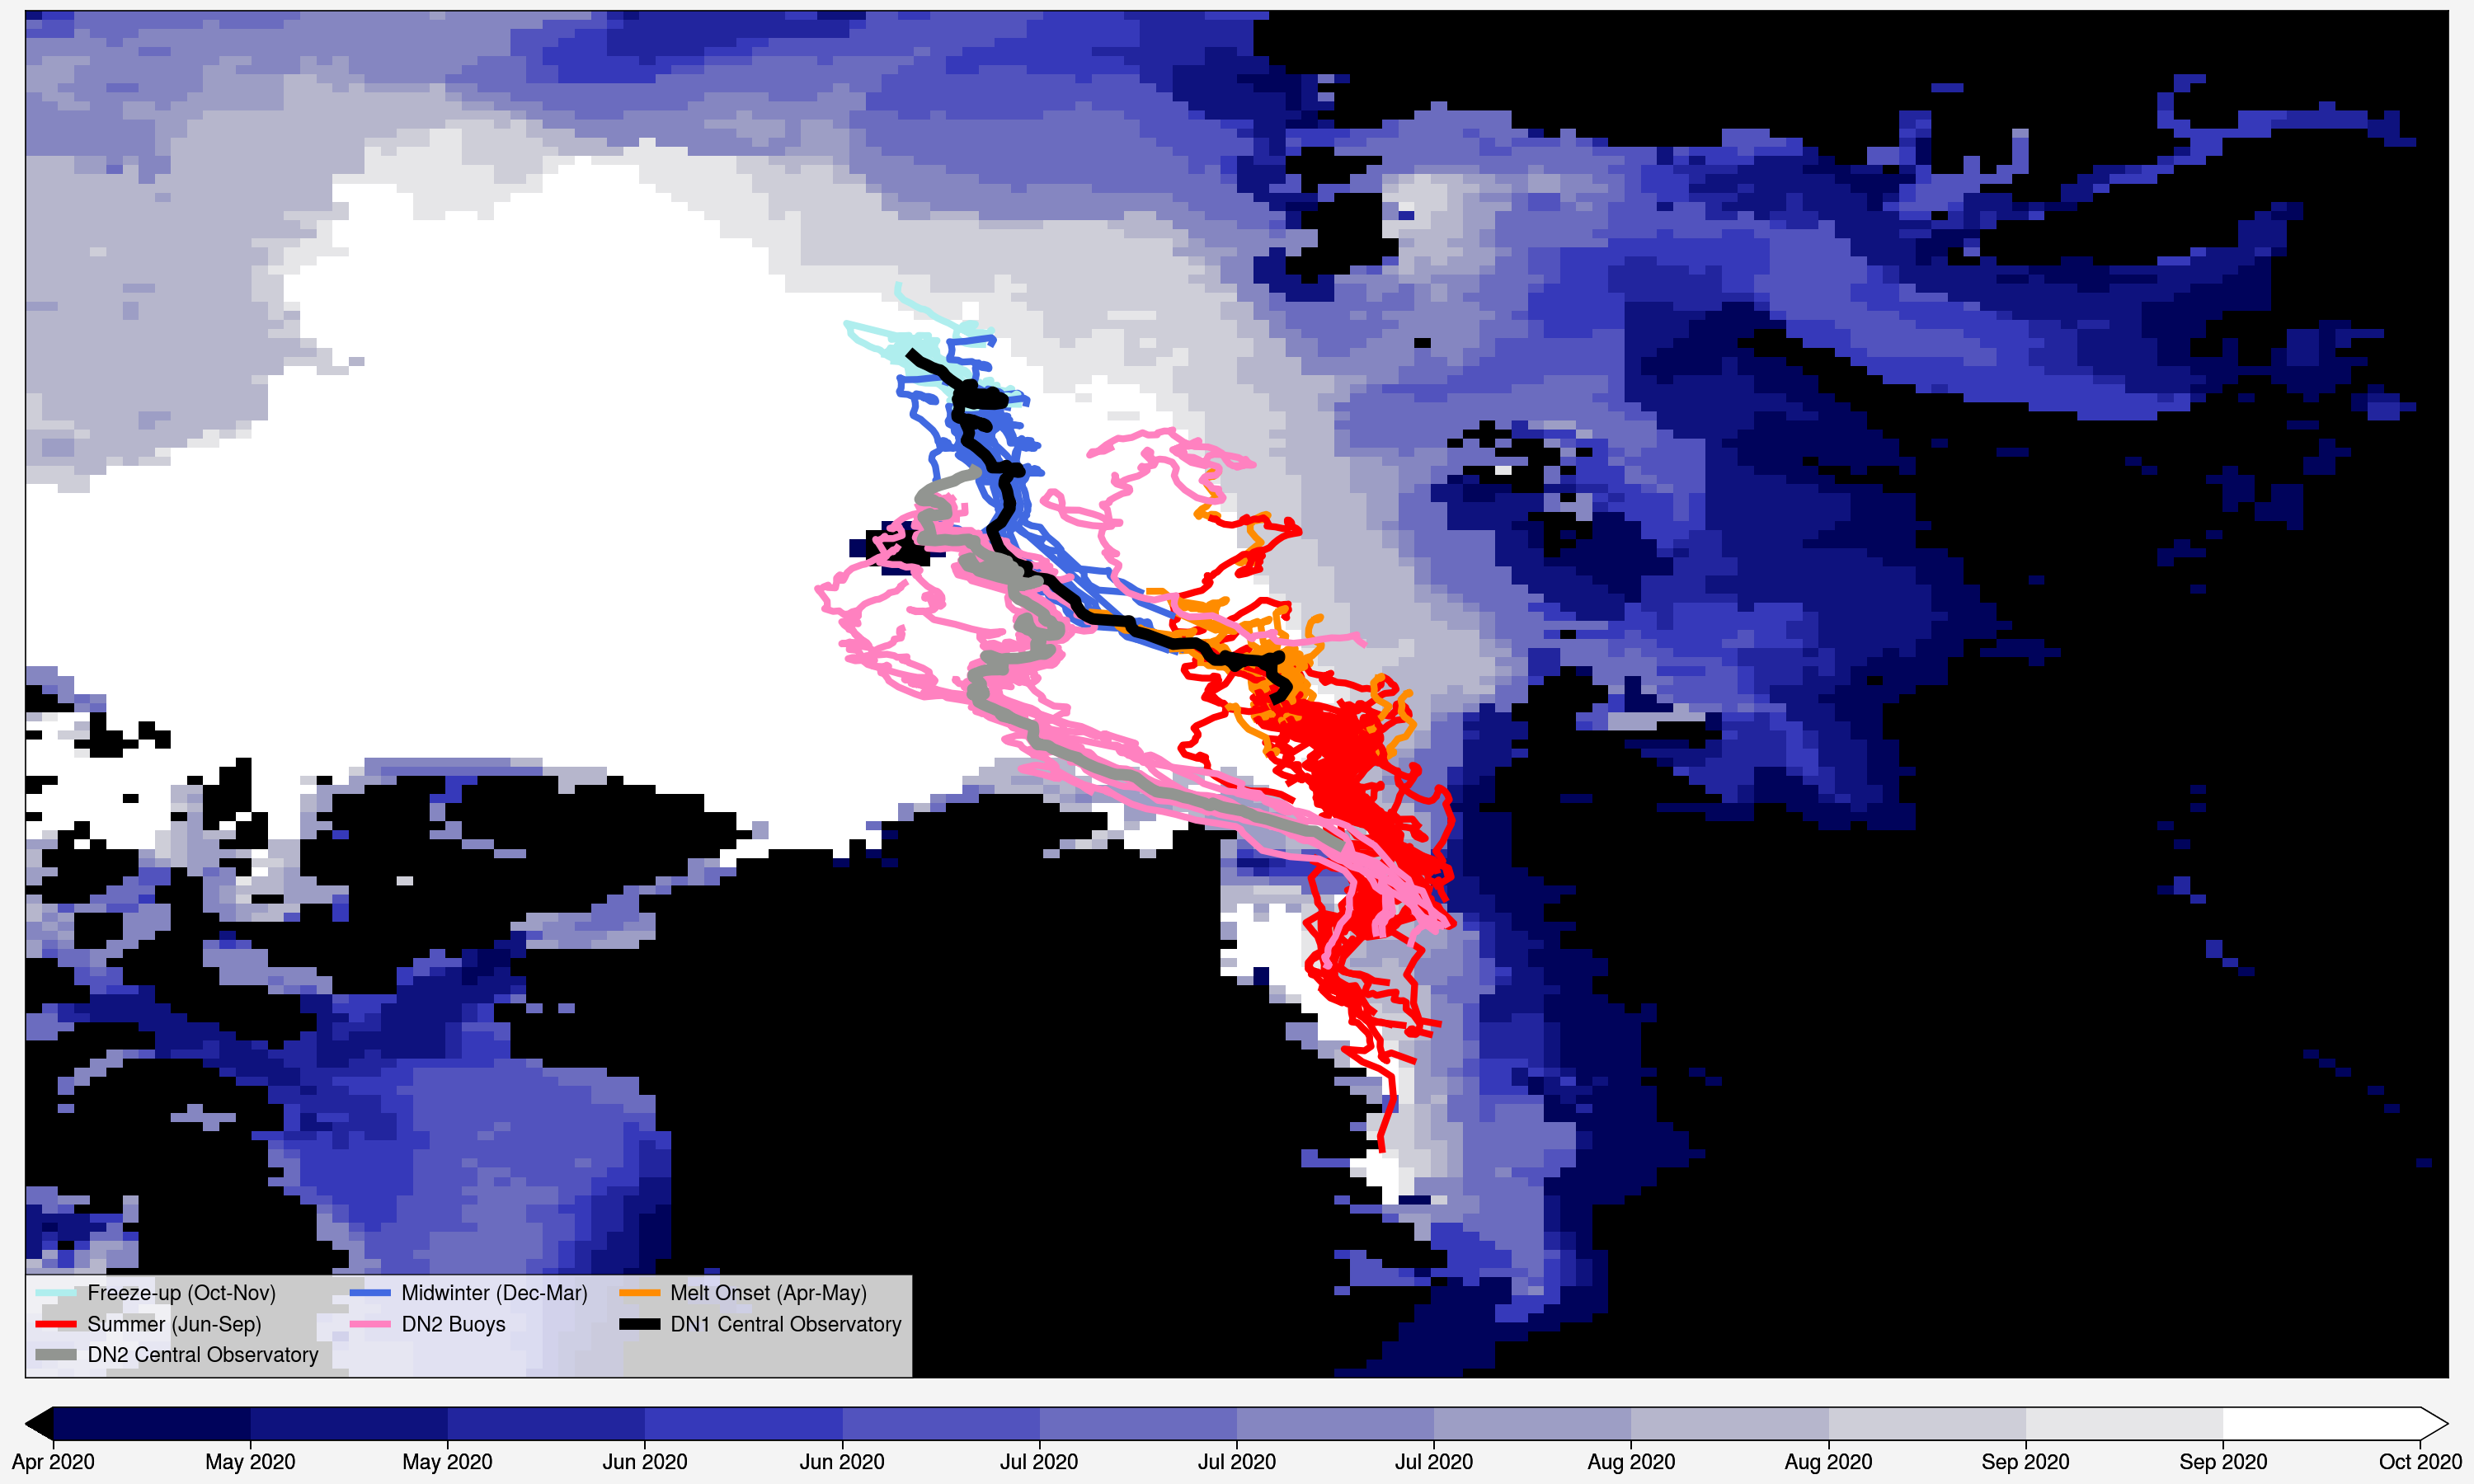

In [15]:
import warnings
import pyproj
warnings.filterwarnings('ignore')

fig, ax = pplt.subplots(figsize=(15,9))
ax.set_xlabel("")
ax.set_ylabel("")


snapshot = getMeltTimes(sic)
#snapshot = np.rot90(np.rot90(snapshot))

cmap = pplt.Colormap(['dark blue', 'white']).with_extremes(under="black")
bounds = np.linspace(0, len(times)-1, 13)
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
mesh = ax.pcolormesh(xvals, yvals,snapshot,
                     cmap=cmap, 
                     norm=norm, extend="both")
             
ax.format(xlocator='null', ylocator='null')

colors = ["paleturquoise",
          "royalblue",
          "darkorange",
          "red"]

def plotOnSIC(data, **kwargs):
    ax.line(data["x_stere"], data["y_stere"], **kwargs)

station_list = station_metadata()
dn1 = list(station_list[station_list["Deployment Leg"] != 5].index)
dn2 = list(station_list[station_list["Deployment Leg"] == 5].index)

for station in dn1:
    data = cropBuoyTrack(station_data(station))
    data["datetime"] = pd.to_datetime(data["datetime"])
    data = varClassifier(data,"datetime","season",season_ranges)

    data.index = data["datetime"]
    
    season_groups = data.groupby("season", as_index=False)
    for group, group_data in season_groups:
        plotOnSIC(group_data, color=colors[group], label=seasons[group], lw=3)

for station in dn2:
    data = cropBuoyTrack(station_data(station))
    plotOnSIC(data, color="pink", label="DN2 Buoys", lw=3)

plotOnSIC(station_data("CO1"), color="black", label="DN1 Central Observatory", lw=5)
plotOnSIC(station_data("CO3"), color="grey", label="DN2 Central Observatory", lw=5)

ax.format(xreverse=False, yreverse=False)

legend_without_duplicate_labels(ax)
fig.colorbar(mesh, loc='b', 
             spacing='proportional', 
             orientation="horizontal",
             format=pplt.Formatter('func', func=dateFormatter))

In [16]:
# %run ../scripts/sic_cutoff.py